### Selection criteria
type: small molecule  
group: approved  
route: oral

In [1]:
import untangle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Parsing Drugbank XML

In [2]:
#takes 5 minutes
filename = "drugbank_20180402.xml" # DrugBank Version 5.1.0 (release date: 2018.04.20) 
obj = untangle.parse(filename)

### Building a dataframe to small molecule data

In [88]:
#Data Frame of DrugBank Small Molecule Type Drugs
df_drugbank_sm = pd.DataFrame(columns=["drugbank_id","name","min dosage strength value", 
                                       "min dosage strength unit", "max dosage strength value",
                                       "max dosage strength unit","route", "form","group",
                                       "kinase inhibitor category","cas","smiles",
                                       "ALOGPS solubility value", "ALOGPS solubility unit"])
df_drugbank_sm

,drugbank_id,name,min dosage strength value,min dosage strength unit,max dosage strength value,max dosage strength unit,route,form,group,kinase inhibitor category,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit


In [89]:
# Takes around 10 minutes to run.
i=-1
#iterate over drug entries to extract information
for drug in obj.drugbank.drug:
    
    #print(drug)
    drug_type = str(drug["type"])
    
    # select for small molecule drugs
    if drug_type in ["small molecule", "Small Molecule", "Small molecule"]:
        i=i+1
        print(drug.name.cdata)
        
        # Select drugs that are in approved group
        
        drug_groups = []
        for group in drug.groups.group:
            group_label = group.cdata
            drug_groups.append(group_label) 

        # If drug does not belong to "approved" group skip
        if "approved" not in  drug_groups:
            continue

        # Check if there is any product data and skip otherwise
        if len(drug.products) == 0:
            continue
            
        # Skip drugs that don't have product strength listed (such as topical drug "DB00027")
        strength_info = ""
        for product in drug.products.product:
            strength_info = strength_info + product.strength.cdata
        if len(strength_info) == 0:
            continue    
        
        # Annotate drugs that belong to kinase inibitor drug category
        
        # Check if category information is available
        if len(drug.categories) == 0:
            df_drugbank_sm.loc[i, "kinase inhibitor category"] = "unknown"
        else:
            # Collect all category labels in a set
            category_set = set()
        
            for category in drug.categories.category:
                category_label = category.category.cdata
                #print(category_label)
                category_set.add(category_label)
            
            drug_category = []
            # Record "True" in the database if it belongs to "Kinase Inhibitor" category
            if "Kinase Inhibitor" in category_set:
                drug_category.append("Kinase Inhibitor")
            if "Protein Kinase Inhibitors" in category_set:
                drug_category.append("Protein Kinase Inhibitor")
            
            if len(drug_category) >= 1:  # This is a kinase inhibitor
                df_drugbank_sm.loc[i, "kinase inhibitor category"] = "True"
            else:
                df_drugbank_sm.loc[i, "kinase inhibitor category"] = "False"
            
        #Get drugbank_id
        for id in drug.drugbank_id:
            if str(id["primary"])=="true":
                df_drugbank_sm.loc[i, "drugbank_id"]=id.cdata

        #Drug name
        df_drugbank_sm.loc[i,"name"]=drug.name.cdata

        #Drug CAS
        df_drugbank_sm.loc[i, "cas"]=drug.cas_number.cdata

        # Drug group    
        df_drugbank_sm.loc[i, "group"] = drug_groups

        #Get SMILES, logP, Solubility
        #Skip drugs with no structure. ("DB00386","DB00407","DB00702","DB00785","DB00840",
        #                                            "DB00893","DB00930","DB00965", "DB01109","DB01266",
        #                                           "DB01323", "DB01341"...)
        if len(drug.calculated_properties.cdata)==0: #If there is no calculated properties
            continue
        else:
            for property in drug.calculated_properties.property:
                if property.kind.cdata == "SMILES":
                    df_drugbank_sm.loc[i, "smiles"]=property.value.cdata

                if property.kind.cdata == "Water Solubility":
                    solubility_value, solubility_unit = property.value.cdata.split(" ") 
                    df_drugbank_sm.loc[i, "ALOGPS solubility value"] = float(solubility_value)
                    df_drugbank_sm.loc[i, "ALOGPS solubility unit"] = solubility_unit

        # Dosage strength 

        # Save dosage information of all products in df_strength
        df_strength = pd.DataFrame(columns=["value", "unit", "route", "form"])

        for p_i, product in enumerate(drug.products.product):

            # check if strength information is available and skip otherwise 
            if len(product.strength.cdata) == 0:
                continue

            # split the value and unit of dosage strength
            try:
                try:
                    strength_value, strength_unit = product.strength.cdata.split(" ")
                except ValueError:    
                    strength_value, strength_unit, extra = product.strength.cdata.split(" ")
                    strength_unit = strength_unit + extra
            except ValueError: 
                strength_value, strength_unit, ext1, ext2, ext3 = product.strength.cdata.split(" ")
                strength_unit = strength_unit + ext1 + ext2 + ext3

            df_strength.loc[p_i, "value"] = float(strength_value)
            df_strength.loc[p_i, "unit"] = strength_unit
            df_strength.loc[p_i, "form"] = product.dosage_form.cdata
            df_strength.loc[p_i, "route"] = product.route.cdata

        # Sort df_strength based on value column, ascending
        df_strength_sorted = df_strength.sort_values("value")
        df_strength_sorted= df_strength_sorted.reset_index(drop=True)

        # Save the info related to the minimum dosage strength to df_drugbank_sm
        df_drugbank_sm.loc[i, "min dosage strength value"] = df_strength_sorted.loc[0, "value"]
        df_drugbank_sm.loc[i, "min dosage strength unit"] = df_strength_sorted.loc[0, "unit"]
        df_drugbank_sm.loc[i, "route"] = df_strength_sorted.loc[0, "route"]
        df_drugbank_sm.loc[i, "form"] = df_strength_sorted.loc[0, "form"] 

        # Sort df_strength based on value column, descending
        df_strength_sorted = df_strength.sort_values("value", ascending=False)
        df_strength_sorted= df_strength_sorted.reset_index(drop=True)

        # Save the info related to the max dosage strength to df_drugbank_sm
        df_drugbank_sm.loc[i, "max dosage strength value"] = df_strength_sorted.loc[0, "value"]
        df_drugbank_sm.loc[i, "max dosage strength unit"] = df_strength_sorted.loc[0, "unit"]

   # if i == 500:
   #     break

df_drugbank_sm = df_drugbank_sm.reset_index(drop=True)

Bivalirudin
Goserelin
Gramicidin D
Desmopressin
Cetrorelix
Vasopressin
Daptomycin
Cyclosporine
Felypressin
Octreotide
Abarelix
Pyridoxal Phosphate
Cyanocobalamin
Tetrahydrofolic acid
Histidine
Ademetionine
Pyruvic acid
L-Phenylalanine
Biotin
Choline
L-Lysine
L-Arginine
Vitamin C
Spermine
L-Aspartic Acid
Ornithine
L-Glutamine
Adenosine monophosphate
Alpha-Linolenic Acid
Serine
Methionine
L-Tyrosine
Calcitriol
Lutein
Cystine
Succinic acid
Riboflavin
N-Acetylglucosamine
Glutamic Acid
Glutathione
Phosphatidyl serine
Glycine
Calcidiol
Pyridoxal
Creatine
L-Leucine
L-Tryptophan
L-Cysteine
Thiamine
Ergocalciferol
Dihomo-gamma-linolenic acid
L-Citrulline
L-Threonine
NADH
Folic Acid
Icosapent
L-Alanine
L-Valine
Vitamin A
Vitamin E
Pyridoxine
Lipoic Acid
L-Isoleucine
Aspartame
Cholecalciferol
Menadione
ATP
L-Proline
Adenine
L-Asparagine
Pravastatin
Fluvoxamine
Valsartan
Ramipril
Masoprocol
Flunisolide
Baclofen
Amphetamine
Pentagastrin
Nicotine
Cevimeline
Lorazepam
Esmolol
Bortezomib
Ethchlorvynol

Propiomazine
Roxithromycin
Nalidixic Acid
Phenelzine
Polymyxin B Sulfate
Propantheline
Estradiol
Mefenamic acid
Cryptenamine
Marimastat
Aciclovir
Naproxen
Gadopentetate dimeglumine
Perindopril
Uracil mustard
Tripelennamine
Haloprogin
Primidone
Sulfasalazine
Candesartan cilexetil
Tolazoline
Gentamicin
Tazarotene
Fenoldopam
Halazepam
Alfentanil
Colistin
Dicyclomine
Minaprine
Pentoxifylline
Proparacaine
Indapamide
Tropicamide
Biperiden
Ribavirin
Phenylbutazone
Fentanyl
Meloxicam
Sodium lauryl sulfate
Orciprenaline
Rosoxacin
Propofol
Acetazolamide
Tadalafil
Carprofen
Disulfiram
Ethynodiol diacetate
Enprofylline
Menthol
Natamycin
Cinoxacin
Fosfomycin
Diazepam
Phenmetrazine
Trifluoperazine
Phensuximide
Cefaclor
Mifepristone
Brompheniramine
Loperamide
Progabide
Clocortolone
Tolazamide
Hydroxypropyl cellulose
Dobutamine
Oxazepam
Donepezil
Nalbuphine
Clofazimine
Flurandrenolide
Cysteamine
Levamisole
Methylphenobarbital
Perphenazine
Dacarbazine
Pseudoephedrine
Temozolomide
Levorphanol
Aminolevul

Probucol
Tiaprofenic acid
Lopinavir
Bacampicillin
Meticillin
Pivampicillin
Pivmecillinam
Tazobactam
Ticarcillin
Propericiazine
Deferasirox
Valganciclovir
Hydroxychloroquine
Amyl Nitrite
Erythrityl Tetranitrate
Acepromazine
Aceprometazine
Alverine
Molindone
Phenindamine
Pheniramine
Pipotiazine
Thioproperazine
Thiothixene
Zuclopenthixol
Isopropamide
Pargyline
Lincomycin
Etoricoxib
5-Fluorouridine
SC-74020
Methyl Nonanoate (Ester)
Alpha-Phosphoribosylpyrophosphoric Acid
Deoxy-2-Fluoro-B-D-Cellotrioside
2-Oxy-4-Hydroxy-5-(2-Hydrazinopyridine)Phenylalanine
2,2-Dimethylthiazolidine-4-Carboxylic Acid;(Dmt)Thiazolidine
Clorocruoro Hem
3,7,11,15-Tetramethyl-Hexadecan-1-Ol
Sorbitol
N-Methyl-Pyridoxal-5'-Phosphate
(5r)-6-(4-{[2-(3-Iodobenzyl)-3-Oxocyclohex-1-En-1-Yl]Amino}Phenyl)-5-Methyl-4,5-Dihydropyridazin-3(2h)-One
(5z)-2-[(1s,2r)-1-Amino-2-Hydroxypropyl]-5-[(4-Amino-1h-Indol-3-Yl)Methylene]-3-(2-Hydroxyethyl)-3,5-Dihydro-4h-Imidazol-4-One
O1-Methyl-Glucose
Thymidine-5'-Phosphate
3,6-Dihydrox

5-Bromo-N[2-(Dimethylamino)Ethyl]-9-Aminoacridine-4-Carboxamide
2-Amino-7-[2-(2-Hydroxy-1-Hydroxymethyl-Ethylamino)-Ethyl]-1,7-Dihydro-Purin-6-One
D-Gluco-2,5-Anhydro-1-Deoxy-1-Phosphonohexitol-6-Phosphate
Oxiranpseudoglucose
3-Hydroxymethyl-5-Aziridinyl-1methyl-2-[1h-Indole-4,7-Dione]-Propanol
Methylethylamine
O-(2-Acetamido-2-Deoxy-Alpha-D-Galactopyranosyl)-L-Serine
6-[N-(4-(Aminomethyl)Phenyl)Carbamyl]-2-Naphthalenecarboxamidine
L-Rhamnitol
5-Methoxy-1,2-Dimethyl-3-(4-Nitrophenoxymethyl)Indole-4,7-Dione
4-Hydroxy-1,2,5-Oxadiazole-3-Carboxylic Acid
5-(4-Methoxyphenoxy)-2,4-Quinazolinediamine
2-Fluoroaniline
1-Deoxy-1-Thio-Heptaethylene Glycol
12-Bromododecanoic Acid
N-Valeric Acid
6-O-Cyclohexylmethyl Guanine
(3s)-3-Amino-1-(Cyclopropylamino)Heptane-2,2-Diol
(1r,4s)-2-Azabornane
2-Acetyl-3-[(4-Amino-2-Methyl-5-Pyrimidinyl)Methyl]-4-Methyl-5-(4,6,6-Trihydroxy-3,5-Dioxa-4,6-Diphosphahex-1-Yl)Thiazolium Inner Salt P,P'-Dioxide
2-(11-{2-[Benzenesulfonyl-(3-Methyl-Butyl)-Amino]-1-Hydroxy-

Mant-Adp
Benzamidine
Acetylcholine
[3-(1,3,2-Dioxaborolan-2-Yloxy)Propyl]Guanidine
S-P-Nitrobenzyloxycarbonylglutathione
3-(2-Benzothiazolylthio)-1-Propanesulfonic Acid
2-(Beta-D-Glucopyranosyl)-5-Methyl-1,2,3-Benzimidazole
2-Aminopimelic Acid
[2(Formyl-Hydroxy-Amino)-Ethyl]-Phosphonic Acid
4-Iodobenzo[B]Thiophene-2-Carboxamidine
8-(2,5-Dimethoxy-Benzyl)-2-Fluoro-9-Pent-9h-Purin-6-Ylamine
Perchlorate
6-[5-(2-Oxo-Hexahydro-Thieno[3,4-D]Imidazol-4-Yl)-Pentanoylamino]-Hexanoic Acid
4-Carboxyphenylboronic Acid
3-{[(5R,6R)-5-Benzyl-6-hydroxy-2,4-bis(4-hydroxybenzyl)-3-oxo-1,2,4-triazepan-1-yl]sulfonyl}benzonitril
Alpha-L-Arabinose
Nonan-1-Ol
N-Omega-Hydroxy-L-Arginine
4-Methyl-5-Hydroxyethylthiazole Phosphate
2-deazo-6-thiophosphate guanosine-5'-monophosphate
Flavin adenine dinucleotide
Phosphomethylphosphonic Acid Adenosyl Ester
2',3'-Dideoxythymidine-5'-Monophosphate
(Mu-4-Sulfido)-Tetra-Nuclear Copper Ion
B-2-Octylglucoside
3h-Pyrazolo[4,3-D]Pyrimidin-7-Ol
{[7-(Difluoro-Phosphono-Methyl)

(S)-N-(3-Indol-1-Yl-2-Methyl-Propyl)-4-Sulfamoyl-Benzamide
N-acetyl-D-glucosamine-6-phosphate
9-(6-deoxy-beta-D-allofuranosyl)-6-methylpurine
L-Thiocitrulline
1-deoxymannojirimycin
Inositol 2,4,5-trisphosphate
SP2456
7-methyl-guanosine-5'-triphosphate-5'-guanosine
N,O6-Disulfo-Glucosamine
Cp-Coeleneterazine
2c-Methyl-D-Erythritol 2,4-Cyclodiphosphate
Nicotinamide 8-Bromo-Adenine Dinucleotide Phosphate
S-(Dimethylarsenic)Cysteine
4-Hydroxy-Aconitate Ion
Clorobiocin
Dodecyl Sulfate
1-Methyl-2-Oxy-5,5-Dimethyl Pyrrolidine
(7R)-7-(6,7-Dihydro-5H-cyclopenta[d]imidazo[2,1-b][1,3]thiazol-2-yl)-2,7-dihydro-1,4-thiazepine-3,6-dicarboxylic acid
Acarbose Derived Hexasaccharide
2-Amino-4h-1,3-Benzoxathiin-4-Ol
3-{2,6,8-trioxo-9-[(2R,3R,4R)-2,3,4,5-tetrahydroxypentyl]-1,2,3,6,8,9-hexahydro-7H-purin-7-Yl}propyl dihydrogen phosphate
L-Homoarginine
Mercuribenzoic Acid
Phosphorylisopropane
N-Trimethyllysine
Tyrosinal
1-[Glycerolylphosphonyl]-2-[8-(2-Hexyl-Cyclopropyl)-Octanal-1-Yl]-3-[Hexadecanal-1-Yl]

(13S)-13-METHYLDODECAHYDRO-1H-CYCLOPENTA[A]PHENANTHRENE-3,17(2H,4H)-DIONE
2,6-anhydro-3-deoxy-3-fluoronononic acid
FARNESYL THIOPYROPHOSPHATE
4-CHLORO-3',3''-DIBROMOPHENOL-1,8-NAPHTHALEIN
TRANS-4-(GUANIDINOMETHYL)-CYCLOHEXANE-L-YL-D-3-CYCLOHEXYLALANYL-L-AZETIDINE-2-YL-D-TYROSINYL-L-HOMOARGININAMIDE
N-(1,4-DIHYDRO-5H-TETRAZOL-5-YLIDENE)-9-OXO-9H-XANTHENE-2-SULFONAMIDE
gamma-butyrolactone
GLUTATHIONE SULFINATE
S-METHYL-GLUTATHIONE
S-[(2E)-3,7-DIMETHYLOCTA-2,6-DIENYL] TRIHYDROGENTHIODIPHOSPHATE
HESPERIDIN
20-hydroxycholesterol
(3BETA)-CHOLEST-5-ENE-3,25-DIOL
(3BETA,7BETA)-CHOLEST-5-ENE-3,7-DIOL
Hydroxyfasudil
(S)-TETRAHYDROFURAN-3-YL (2S,3S)-4-((S)-4-((1R,3R)-3-(2-AMINO-2-OXOETHYL)-2,3-DIHYDRO-1H-INDEN-1-YL)-2-BENZYL-3-OXO-2,3-DIHYDRO-1H-PYRROL-2-YL)-3-HYDROXY-1-PHENYLBUTAN-2-YLCARBAMATE
(3AALPHA,4ALPHA,7ALPHA,7AALPHA)- 3A,4,7,7A-TETRAHYDRO-2-(4-NITRO-1-NAPHTHALENYL)-4,7-ETHANO-1H-ISOINDOLE-1,3(2H)-DIONE
(E)-(S)-4-[(S)-4-METHYL-2-((S)-3-METHYL-2{(S)-2-[(5-METHYL-ISOXAZOLE-3- CARBONYL)-AMI

Talnetant
Evernimicin
Tezacitabine
Repifermin
Tarazepide
Semaxanib
Tifacogin
Tyloxapol
Ravuconazole
Cangrelor
Avasimibe
Dexanabinol
Diethylnorspermine
Dotarizine
Lonafarnib
Ilodecakin
Aprinocarsen
Mirostipen
Sarizotan
Meclinertant
Tecastemizole
Remacemide
Enrasentan
Squalamine
Cariporide
Lestaurtinib
clomethiazole
Naxifylline
Fradafiban
Sumanirole
Porfiromycin
Propentofylline
Prucalopride
Manitimus
ALGRX 1207
Ropidoxuridine
Enzastaurin
Velafermin
Sufugolix
S-8510
Repinotan
Muraglitazar
Deramciclane
Resiniferatoxin
Edaglitazone
Ertiprotafib
Levovirin
Ganstigmine
Tramiprosate
Ocinaplon
Resiquimod
Pafuramidine
Ragaglitazar
Etilevodopa
Tesaglitazar
Robalzotan
Astaxanthin
Minodronic acid
Labradimil
Gaboxadol
Siramesine
Edifoligide
Tezosentan
Lanimostim
Emfilermin
alpha-Hydroxy glycineamide
Rebimastat
Valomaciclovir
Tonabersat
Adipiplon
Celgosivir
Bevirimat
Dextofisopam
Fipamezole
Cetilistat
Mitemcinal
Triphendiol
Pazopanib
Ceftaroline fosamil
Agomelatine
Midostaurin
Brostallicin
Nemonoxacin

2-{[4-(TRIFLUOROMETHOXY)BENZOYL]AMINO}ETHYL DIHYDROGEN PHOSPHATE
3-ETHYL-6-{[(4-FLUOROPHENYL)SULFONYL]AMINO}-2-METHYLBENZOIC ACID
(3R)-N-(4-CHLOROPHENYL)-3-(HYDROXYMETHYL)-1,2,3,4-TETRAHYDROISOQUINOLINE-7-SULFONAMIDE
2-({[4-(TRIFLUOROMETHOXY)PHENYL]SULFONYL}AMINO)ETHYL DIHYDROGEN PHOSPHATE
2-ACETYLAMINO-4-METHYL-PENTANOIC ACID (1-FORMYL-2-PHENYL-ETHYL)-AMIDE
(2R)-1-[4-({4-[(2,5-Dichlorophenyl)amino]-2-pyrimidinyl}amino)phenoxy]-3-(dimethylamino)-2-propanol
(2S)-1-[4-({6-[(2,6-Difluorophenyl)amino]-4-pyrimidinyl}amino)phenoxy]-3-(dimethylamino)-2-propanol
3',5'-DIFLUOROBIPHENYL-4-CARBOXYLIC ACID
N-({(1R)-1-carboxy-2-[(4-fluorobenzyl)sulfanyl]ethyl}carbamoyl)-L-glutamic acid
(2S)-1-[4-({4-[(2,5-Dichlorophenyl)amino]-2-pyrimidinyl}amino)phenoxy]-3-(dimethylamino)-2-propanol
1-[3-({[(4-AMINO-5-FLUORO-2-METHYLQUINOLIN-3-YL)METHYL]THIO}METHYL)PHENYL]-2,2,2-TRIFLUOROETHANE-1,1-DIOL
(9aS)-4-bromo-9a-butyl-7-hydroxy-1,2,9,9a-tetrahydro-3H-fluoren-3-one
5-(2,5-DICHLOROPHENYL)-2-FUROIC ACID
5-[2-

HYDROXY[3-(6-METHYLPYRIDIN-2-YL)PROPYL]FORMAMIDE
CARBOBENZYLOXY-(L)-LEUCINYL-(L)LEUCINYL METHOXYMETHYLKETONE
1-[4-(AMINOSULFONYL)PHENYL]-1,6-DIHYDROPYRAZOLO[3,4-E]INDAZOLE-3-CARBOXAMIDE
2-AMINO-6-(3,5-DIMETHYLPHENYL)SULFONYLBENZONITRILE
(6E,11E)-HEPTADECA-6,11-DIENE-9,9-DIYLBIS(PHOSPHONIC ACID)
7-BENZYL-1,3-DIMETHYL-8-PIPERAZIN-1-YL-3,7-DIHYDRO-PURINE-2,6-DIONE
5-(2,3-dichlorophenyl)-N-(pyridin-4-ylmethyl)pyrazolo[1,5-a]pyrimidin-7-amine
6-(2-fluorophenyl)-N-(pyridin-3-ylmethyl)imidazo[1,2-a]pyrazin-8-amine
3-methyl-N-(pyridin-4-ylmethyl)imidazo[1,2-a]pyrazin-8-amine
5-(2-fluorophenyl)-N-(pyridin-4-ylmethyl)pyrazolo[1,5-a]pyrimidin-7-amine
3-bromo-5-phenyl-N-(pyridin-3-ylmethyl)pyrazolo[1,5-a]pyrimidin-7-amine
3-bromo-5-phenyl-N-(pyrimidin-5-ylmethyl)pyrazolo[1,5-a]pyridin-7-amine
3-bromo-6-phenyl-N-(pyrimidin-5-ylmethyl)imidazo[1,2-a]pyridin-8-amine
N-((2-aminopyrimidin-5-yl)methyl)-5-(2,6-difluorophenyl)-3-ethylpyrazolo[1,5-a]pyrimidin-7-amine
3-cyclopropyl-5-phenyl-N-(pyridin-3-ylme

Tesamorelin
Eribulin
Gabapentin Enacarbil
Boceprevir
Fidaxomicin
Cabozantinib
Ruxolitinib
Aminopterin
Teriflunomide
Vemurafenib
Linagliptin
Perampanel
Gadoxetic acid
Icosapent ethyl
Carfilzomib
Linaclotide
Arbaclofen
Arbaclofen Placarbil
Mirabegron
Tofacitinib
Regorafenib
Aclidinium
Enzalutamide
Ponatinib
Bedaquiline
Formestane
Fluticasone furoate
Canagliflozin
Dimethyl fumarate
Glycerol Phenylbutyrate
Pomalidomide
Trametinib
Dabrafenib
Radium Ra 223 Dichloride
Aleglitazar
Afatinib
Ferric Carboxymaltose
Levomilnacipran
(4R)-limonene
Perospirone
Amfecloral
Adrafinil
Acediasulfone
Amperozide
Arsthinol
Dolutegravir
Riociguat
Macitentan
Luliconazole
Sofosbuvir
Chlorcyclizine
TAS-102
Magaldrate
Letosteine
Kebuzone
Isoxsuprine
Isoxicam
Isoconazole
Isoaminile
Iotroxic acid
Iopanoic acid
Iopamidol
Iodamide
Inositol nicotinate
Indoramin
Indoprofen
Indenolol
Indalpine
Ifenprodil
Ibuproxam
Hydroxydione
Hexoprenaline
Hexetidine
Hexamethonium
Azosemide
Glibornuride
Gemeprost
Fusafungine
Fursultiami

Sulisobenzone
Pentoxyverine
Magnesium glycinate
Pantethine
Cobamamide
Papain
Xylitol
Peppermint oil
Sage oil
Aluminum zirconium octachlorohydrex gly
N-alkyl ethylbenzyl dimethyl ammonium (c12-c14)
Boron
Alcloxa
Bemotrizinol
Aluminum chlorohydrex propylene glycol
Iron protein succinylate
Ferrous bisglycinate
Potassium dichromate
Arbutin
Tea tree oil
Enzacamene
Octacosanol
Benzoin
Methyl cellulose
Lycopene
Poliglusam
Thonzylamine
Trypsin
Borage oil
Aluminum sulfate
Dextran 75
Gelatin
Ethyl macadamiate
Cyclomethicone 5
Copper gluconate
Zinc gluconate
Tocopherol
Poloxamer 407
Xanthan gum
Hexylresorcinol
Chromium picolinate
Levomefolic acid
Fluoride ion
Ceramide 3
Diosmetin
Diacetyl benzoyl lathyrol
Atractylodes japonica root
Polydatin
Calcium glycerophosphate
Sea salt
Protocatechualdehyde
Atractylodes japonica root oil
Methyl undecenoyl leucinate
Pine needle oil (pinus mugo)
Aluminum zirconium pentachlorohydrex gly
Brilliant green
Docosahexaenoate
Rice bran oil
Trichophyton verrucosum
Prez

Fluocinolone
Mebeverine
Nelotanserin
MK-5108
FK-614
AEE-788
EC-17
WNT-974
Setipiprant
MK-0686
Gemcitabine elaidate
Abexinostat
Decernotinib
Camicinal
Tonapofylline
CC-223
Rimacalib
Pexacerfont
LY-2452473
LY-295501
Ronopterin
AZD-3043
Fosbretabulin
Lexaptepid Pegol
JNJ-37822681
Tradipitant
Ozarelix
Piperine
Maltodextrin
Ondelopran
Anhydrovinblastine
Razupenem
AZD-1480
Indiplon
BMS-911543
EC-18
Apaziquone
AZD-9056
Combretastatin
ABL-001
Nafamostat
Sonolisib
Pentetreotide
Sisomicin
Etripamil
Netivudine
Emixustat
Ebselen
PF-477736
Ozanimod
Davunetide
Reparixin
Plazomicin
Mizoribine
Apocynin
BMS-188797
ST-101
Lupeol
Taprenepag
Octenidine
Evogliptin
GSK-1292263
Methyl-D9-choline
3,5-diiodothyropropionic acid
Isopentyl 2-cyanoacrylate
Aclerastide
JNJ-41443532
BMS-184476
Aleplasinin
Onapristone
PU-H71
CP-609754
Tedatioxetine
Olumacostat glasaretil
Nelivaptan
AZD-2066
Givinostat
Tocotrienol
Nona-arginine
Ibipinabant
L-deprenyl-D2 C-11
Bardoxolone
GSK-376501
Patidegib
JNJ-42396302
AFN-1252
SJ-73

Estradiol benzoate
Estradiol cypionate
Estradiol dienanthate
Estradiol valerate
J147
Trestolone acetate
Medium-chain triglycerides
Bronopol
Fish oil
Calcium saccharate
1,2-dichlorobenzene
Peanut oil
Isopropyl myristate
Patent Blue V
Quaternium-24
Dioctyldimonium
Vanadium
Racemethionine
Passiflora incarnata flower
Cimicifuga racemosa
Potassium carbonate
Selisistat
Copper Cu-64
Nomegestrol acetate
Lutetium Lu-177
5,7,2′-trihydroxy-6,8-dimethoxyflavone
Cyclopropane
Lutetium Lu 177 dotatate
Strontium chloride
SB-269970
Epitizide
Dipropyl-4-hydroxytryptamine
Pipequaline
MRK-409
Ferric pyrophosphate citrate
Magnesium acetate
Baloxavir marboxil
Tetraglyme
alpha-Tocopherol succinate
D-alpha-Tocopherol acetate
alpha-Tocopherol acetate


In [90]:
print(df_drugbank_sm.shape)
df_drugbank_sm.head(20)

(1724, 14)


,drugbank_id,name,min dosage strength value,min dosage strength unit,max dosage strength value,max dosage strength unit,route,form,group,kinase inhibitor category,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit
0,DB00006,Bivalirudin,250,mg,500,mg/100mL,Intravenous,"Powder, for solution","[approved, investigational]",False,128270-60-0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,0.0464,g/l
1,DB00014,Goserelin,3.6,mg/1,10.8,mg/1,Subcutaneous,Implant,[approved],False,65807-02-5,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0.0283,g/l
2,DB00035,Desmopressin,0.1,mg/1,240,mcg,Oral,Tablet,[approved],False,16679-58-6,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0.11,g/l
3,DB00050,Cetrorelix,0.25,mg,3,mg,Subcutaneous,"Injection, powder, for solution","[approved, investigational]",False,120287-85-6,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0.00694,g/l
4,DB00067,Vasopressin,NaN,NaN,NaN,NaN,NaN,NaN,[approved],False,11000-17-2,NaN,NaN,NaN
5,DB00080,Daptomycin,350,mg/7mL,500,mg,Intravenous,"Injection, powder, lyophilized, for solution","[approved, investigational]",False,103060-53-3,CCCCCCCCCC(=O)N[C@@H](CC1=CNC2=C1C=CC=C2)C(=O)...,0.0173,g/l
6,DB00091,Cyclosporine,0.0005,g/100mL,100,mg,Ophthalmic,Liquid,"[approved, investigational, vet_approved]",False,59865-13-3,CC[C@@H]1NC(=O)[C@H]([C@H](O)[C@H](C)C\C=C\C)N...,NaN,NaN
7,DB00104,Octreotide,10,mg,1000,ug/mL,Intramuscular,Powder,"[approved, investigational]",False,83150-76-9,[H][C@]1(NC(=O)[C@H](CCCCN)NC(=O)[C@@H](CC2=CN...,0.0122,g/l
8,DB00115,Cyanocobalamin,0.025,mg,1000,mcg,Oral,Tablet,"[approved, nutraceutical]",False,68-19-9,[C@H]1([C@@H]2[C@H]([C@@H](N3C4=CC(=C(C)C=C4[N...,NaN,NaN
9,DB00121,Biotin,0.002,mL/mL,500,mcg,Topical,Liquid,"[approved, investigational, nutraceutical]",False,58-85-5,[H][C@]12CS[C@@H](CCCCC(O)=O)[C@@]1([H])NC(=O)N2,1.22,g/l


In [91]:
# Save dataframe to csv
df_drugbank_sm.to_csv("dosage_strength_of_approved_small_molecule_drugs.csv")
print(df_drugbank_sm.shape)
df_drugbank_sm.head()

(1724, 14)


,drugbank_id,name,min dosage strength value,min dosage strength unit,max dosage strength value,max dosage strength unit,route,form,group,kinase inhibitor category,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit
0,DB00006,Bivalirudin,250,mg,500,mg/100mL,Intravenous,"Powder, for solution","[approved, investigational]",False,128270-60-0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,0.0464,g/l
1,DB00014,Goserelin,3.6,mg/1,10.8,mg/1,Subcutaneous,Implant,[approved],False,65807-02-5,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,0.0283,g/l
2,DB00035,Desmopressin,0.1,mg/1,240,mcg,Oral,Tablet,[approved],False,16679-58-6,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0.11,g/l
3,DB00050,Cetrorelix,0.25,mg,3,mg,Subcutaneous,"Injection, powder, for solution","[approved, investigational]",False,120287-85-6,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,0.00694,g/l
4,DB00067,Vasopressin,NaN,NaN,NaN,NaN,NaN,NaN,[approved],False,11000-17-2,NaN,NaN,NaN


In [101]:
# Select only oral drugs

df_drugbank_sm_oral = df_drugbank_sm.loc[df_drugbank_sm["route"] == "Oral"]
df_drugbank_sm_oral = df_drugbank_sm_oral.reset_index(drop=True)
df_drugbank_sm.to_csv("dosage_strength_of_approved_oral_small_molecule_drugs.csv")
print(df_drugbank_sm_oral.shape)
df_drugbank_sm_oral.head(10)

(832, 14)


,drugbank_id,name,min dosage strength value,min dosage strength unit,max dosage strength value,max dosage strength unit,route,form,group,kinase inhibitor category,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit
0,DB00035,Desmopressin,0.1,mg/1,240,mcg,Oral,Tablet,[approved],False,16679-58-6,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0.11,g/l
1,DB00115,Cyanocobalamin,0.025,mg,1000,mcg,Oral,Tablet,"[approved, nutraceutical]",False,68-19-9,[C@H]1([C@@H]2[C@H]([C@@H](N3C4=CC(=C(C)C=C4[N...,NaN,NaN
2,DB00122,Choline,100,mg,500,mg,Oral,Tablet,"[approved, nutraceutical]",False,62-49-7,C[N+](C)(C)CCO,3.61,g/l
3,DB00126,Vitamin C,0.3,mg,1250,mg,Oral,Solution,"[approved, nutraceutical]",False,50-81-7,[H][C@@]1(OC(=O)C(O)=C1O)[C@@H](O)CO,245,g/l
4,DB00130,L-Glutamine,5,g/1,5,g/1,Oral,"Powder, for solution","[approved, investigational, nutraceutical]",False,56-85-9,N[C@@H](CCC(N)=O)C(O)=O,97.8,g/l
5,DB00136,Calcitriol,0.25,ug/1,3,ug/g,Oral,"Capsule, liquid filled","[approved, nutraceutical]",False,32222-06-3,C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(...,0.00667,g/l
6,DB00137,Lutein,20,g/100g,20,g/100g,Oral,Capsule,"[approved, investigational, nutraceutical]",False,127-40-2,C\C(\C=C\C=C(/C)\C=C\[C@H]1C(C)=C[C@H](O)CC1(C...,0.000732,g/l
7,DB00142,Glutamic Acid,325,mg,325,mg,Oral,Capsule,"[approved, nutraceutical]",False,56-86-0,N[C@@H](CCC(O)=O)C(O)=O,80.6,g/l
8,DB00146,Calcidiol,30,ug/1,30,ug/1,Oral,"Capsule, extended release","[approved, nutraceutical]",False,19356-17-3,C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(...,0.0022,g/l
9,DB00150,L-Tryptophan,1,g,750,mg,Oral,Tablet,"[approved, nutraceutical, withdrawn]",False,73-22-3,N[C@@H](CC1=CNC2=CC=CC=C12)C(O)=O,1.36,g/l


In [100]:
# I will calculate strenght values in terms of mg (i.e. mg/1)

# Keep the strength value as it is if strength unit is mg or mg/1
# Multiply strength value by 0.001 if strength unit us ug or ug/1
# Multiply strength value by 1000 if strength unit us ug or ug/1


df_drugbank_oral_fixed_unit = pd.DataFrame(columns=df_drugbank_sm_oral.columns)

# Correct min strength values and units
for i, row in enumerate(df_drugbank_sm_oral.iterrows()):
    
    unit = row[1]["min dosage strength unit"]
    strength = row[1]["min dosage strength value"]
    
    # Keep the strength value as it is if strength unit is mg or mg/1
    if unit == "mg" or unit == "mg/1":
        df_drugbank_oral_fixed_unit.loc[i,:] = row[1]
    
    # Multiply strength value by 0.001 if strength unit us ug or ug/1 or mcg
    if unit == "ug" or unit == "ug/1" or unit == "mcg":
        corrected_strength = strength * 0.001
        if unit == "ug" or unit == "mcg" :
            corrected_unit = "mg"
        if unit == "ug/1":
            corrected_unit = "mg/1"
        df_drugbank_oral_fixed_unit.loc[i,:] = row[1]
        df_drugbank_oral_fixed_unit.loc[i,"min dosage strength value"] = corrected_strength
        df_drugbank_oral_fixed_unit.loc[i,"min dosage strength unit"] = corrected_unit
        
    # Multiply strength value by 1000 if strength unit us ug or ug/1
    if unit == "g" or unit == "g/1":
        corrected_strength = strength * 1000
        if unit == "g":
            corrected_unit = "mg"
        if unit == "g/1":
            corrected_unit = "mg/1"
        df_drugbank_oral_fixed_unit.loc[i,:] = row[1]
        df_drugbank_oral_fixed_unit.loc[i,"min dosage strength value"] = corrected_strength
        df_drugbank_oral_fixed_unit.loc[i,"min dosage strength unit"] = corrected_unit

# Correct max strength values and units
for i, row in enumerate(df_drugbank_oral_fixed_unit.iterrows()):
    
    unit = row[1]["max dosage strength unit"]
    strength = row[1]["max dosage strength value"]
    
    # Keep the strength value as it is if strength unit is mg or mg/1
    if unit == "mg" or unit == "mg/1":
        df_drugbank_oral_fixed_unit.loc[i,:] = row[1]
    
    # Multiply strength value by 0.001 if strength unit us ug or ug/1 or mcg
    if unit == "ug" or unit == "ug/1" or unit == "mcg":
        corrected_strength = strength * 0.001
        if unit == "ug" or unit == "mcg" :
            corrected_unit = "mg"
        if unit == "ug/1":
            corrected_unit = "mg/1"
        df_drugbank_oral_fixed_unit.loc[i,:] = row[1]
        df_drugbank_oral_fixed_unit.loc[i,"max dosage strength value"] = corrected_strength
        df_drugbank_oral_fixed_unit.loc[i,"max dosage strength unit"] = corrected_unit
        
    # Multiply strength value by 1000 if strength unit us ug or ug/1
    if unit == "g" or unit == "g/1":
        corrected_strength = strength * 1000
        if unit == "g":
            corrected_unit = "mg"
        if unit == "g/1":
            corrected_unit = "mg/1"
        df_drugbank_oral_fixed_unit.loc[i,:] = row[1]
        df_drugbank_oral_fixed_unit.loc[i,"max dosage strength value"] = corrected_strength
        df_drugbank_oral_fixed_unit.loc[i,"max dosage strength unit"] = corrected_unit

print(df_drugbank_oral_fixed_unit.shape)  
df_drugbank_oral_fixed_unit.head()

(808, 14)


,drugbank_id,name,min dosage strength value,min dosage strength unit,max dosage strength value,max dosage strength unit,route,form,group,kinase inhibitor category,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit
0,DB00035,Desmopressin,0.1,mg/1,0.24,mg,Oral,Tablet,[approved],False,16679-58-6,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,0.11,g/l
1,DB00115,Cyanocobalamin,0.025,mg,1,mg,Oral,Tablet,"[approved, nutraceutical]",False,68-19-9,[C@H]1([C@@H]2[C@H]([C@@H](N3C4=CC(=C(C)C=C4[N...,NaN,NaN
2,DB00122,Choline,100,mg,500,mg,Oral,Tablet,"[approved, nutraceutical]",False,62-49-7,C[N+](C)(C)CCO,3.61,g/l
3,DB00126,Vitamin C,0.3,mg,1250,mg,Oral,Solution,"[approved, nutraceutical]",False,50-81-7,[H][C@@]1(OC(=O)C(O)=C1O)[C@@H](O)CO,245,g/l
4,DB00130,L-Glutamine,5000,mg/1,5000,mg/1,Oral,"Powder, for solution","[approved, investigational, nutraceutical]",False,56-85-9,N[C@@H](CCC(N)=O)C(O)=O,97.8,g/l


In [167]:
df_drugbank_oral_fixed_unit.to_csv("dosage_strength_of_approved_oral_small_molecule_drugs_with_fixed_units.csv")

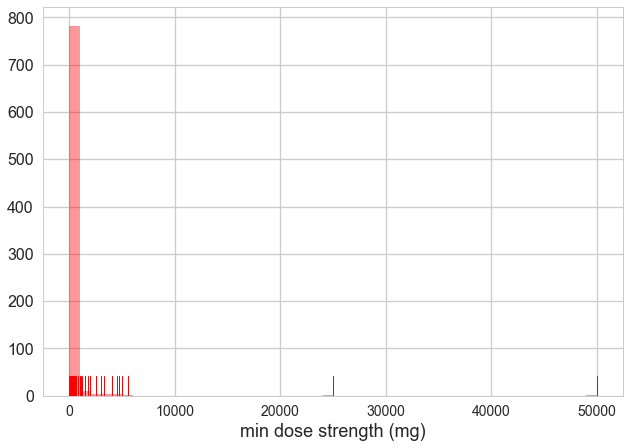

In [171]:
x = np.array(df_drugbank_oral_fixed_unit["min dosage strength value"].values, dtype=np.float64)
x = pd.Series(x, name="min dose strength (mg)")
sns.distplot(x, hist= True, rug = True, kde=False, color = 'red')

Number of approved oral small molecules:
808


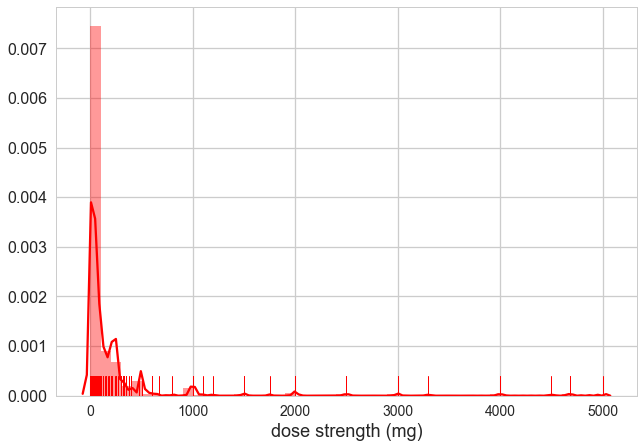

In [112]:
# I want to plot only 0-5000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit.shape[0])

x = np.array(df_drugbank_oral_fixed_unit["min dosage strength value"].values, dtype=np.float64)
x = x[x <= 5000]
x = pd.Series(x, name="dose strength (mg)")
sns.distplot(x, hist= True, rug = True, color = 'red')

Number of approved oral small molecules:
808


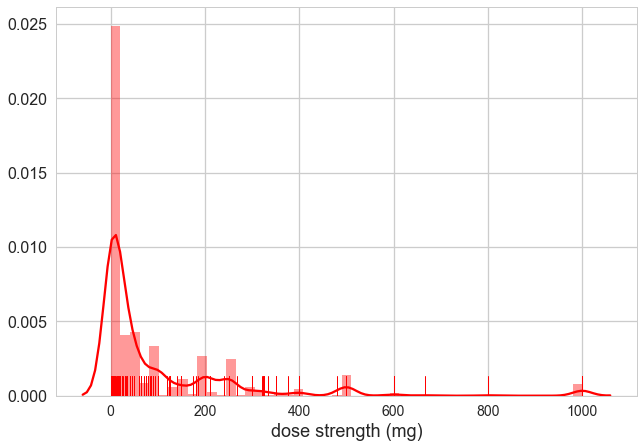

In [115]:
# I want to plot only 0-1000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit.shape[0])

x = np.array(df_drugbank_oral_fixed_unit["min dosage strength value"].values, dtype=np.float64)
x = x[x <= 1000]
x = pd.Series(x, name="dose strength (mg)")
sns.distplot(x, hist= True, rug = True, color = 'red')

Number of approved oral kinase inhibitors:
47


(0, 388.42865671648076)

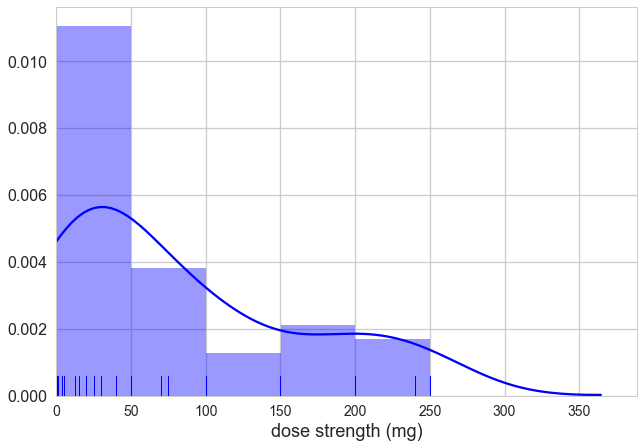

In [164]:
# Plot distribution for all approved oral kinase inhibitors
df_drugbank_oral_fixed_unit_kinase = df_drugbank_oral_fixed_unit.loc[df_drugbank_oral_fixed_unit["kinase inhibitor category"] == "True"]
print("Number of approved oral kinase inhibitors:")
print(df_drugbank_oral_fixed_unit_kinase.shape[0])

k = np.array(df_drugbank_oral_fixed_unit_kinase["min dosage strength value"].values, dtype=np.float64)
k = pd.Series(k, name="dose strength (mg)")
sns.distplot(k, hist= True, rug = True, color = 'blue')
plt.xlim(0, None)

Number of approved oral kinase inhibitors:
47


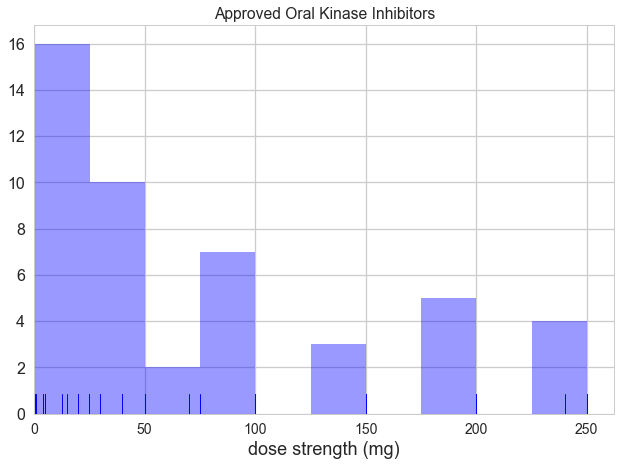

In [165]:
# Plot distribution for all approved oral kinase inhibitors
df_drugbank_oral_fixed_unit_kinase = df_drugbank_oral_fixed_unit.loc[df_drugbank_oral_fixed_unit["kinase inhibitor category"] == "True"]
print("Number of approved oral kinase inhibitors:")
print(df_drugbank_oral_fixed_unit_kinase.shape[0])

k = np.array(df_drugbank_oral_fixed_unit_kinase["min dosage strength value"].values, dtype=np.float64)
k = pd.Series(k, name="dose strength (mg)")
sns.distplot(k, bins = 10, hist= True, rug = True, kde = False, color = 'blue')
plt.xlim(0, None)
plt.title("Approved Oral Kinase Inhibitors")
plt.savefig("dose_strength_histogram_of_approved_oral_kinase_inhibitors.svg")
plt.savefig("dose_strength_histogram_of_approved_oral_kinase_inhibitors.pdf")


Number of approved oral small molecules:
808
Number of approved oral kinase inhibitors:
47


(0, 1049.99999)

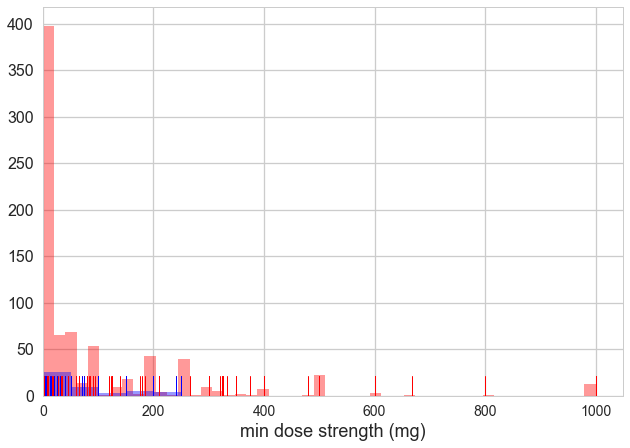

In [166]:
# I want to plot only 0-1000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit.shape[0])

x = np.array(df_drugbank_oral_fixed_unit["min dosage strength value"].values, dtype=np.float64)
x = x[x <= 1000]
x = pd.Series(x, name="min dose strength (mg)")
sns.distplot(x, hist= True, rug = True, kde = False, color = 'red')

# Plot distribution for all approved oral kinase inhibitors
df_drugbank_oral_fixed_unit_kinase = df_drugbank_oral_fixed_unit.loc[df_drugbank_oral_fixed_unit["kinase inhibitor category"] == "True"]
print("Number of approved oral kinase inhibitors:")
print(df_drugbank_oral_fixed_unit_kinase.shape[0])

k = np.array(df_drugbank_oral_fixed_unit_kinase["min dosage strength value"].values, dtype=np.float64)
k = pd.Series(k, name="min dose strength (mg)")
sns.distplot(k, hist= True, rug = True, kde = False, color = 'blue')
plt.xlim(0, None)

### Non-nutrient non-kinase inhibitor oral small molecule drugs

In [127]:
# Let's remove nutritional small molecules from small molecule database
df_drugbank_oral_fixed_unit_nonnut = pd.DataFrame(columns=df_drugbank_sm_oral.columns)

for i, row in enumerate(df_drugbank_oral_fixed_unit.iterrows()):
    group = row[1]["group"]
    if "nutraceutical" in group:
        continue
    else:
        df_drugbank_oral_fixed_unit_nonnut.loc[i,:] = row[1]

print(df_drugbank_oral_fixed_unit_nonnut.shape)

(788, 14)


In [168]:
df_drugbank_oral_fixed_unit_nonnut.to_csv("dosage_strength_of_approved_oral_non-nutritional_small_molecule_drugs_with_fixed_units.csv")

In [146]:
# Let's remove kinase inhibitors from small molecule database
df_drugbank_oral_fixed_unit_nonnut_nonki = pd.DataFrame(columns=df_drugbank_sm_oral.columns)

for i, row in enumerate(df_drugbank_oral_fixed_unit_nonnut.iterrows()):
    kinase_inhibitor = row[1]["kinase inhibitor category"]
    if kinase_inhibitor == "True":
        continue
    else:
        df_drugbank_oral_fixed_unit_nonnut_nonki.loc[i,:] = row[1]

print(df_drugbank_oral_fixed_unit_nonnut_nonki.shape)

(741, 14)


Number of approved oral small molecules that are not kinases or nutritional:
741


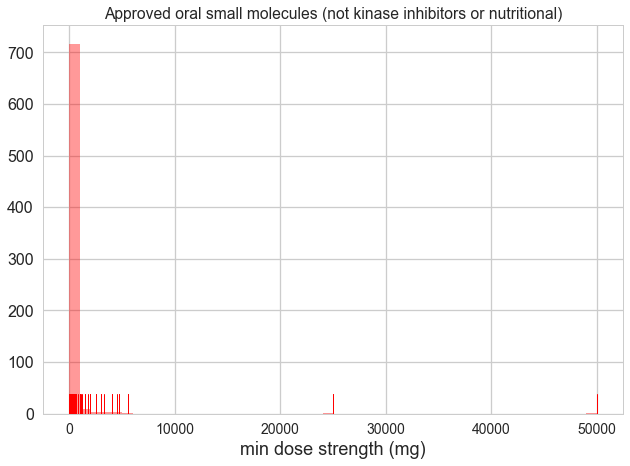

In [172]:
print("Number of approved oral small molecules that are not kinases or nutritional:")
print(df_drugbank_oral_fixed_unit_nonnut_nonki.shape[0])

x = np.array(df_drugbank_oral_fixed_unit_nonnut_nonki["min dosage strength value"].values, dtype=np.float64)
x = pd.Series(x, name="min dose strength (mg)")
sns.distplot(x, hist= True, rug = True, kde = False, color = 'red')
plt.title("Approved oral small molecules (not kinase inhibitors or nutritional)")
plt.savefig("dose_strength_histogram_of_approved_oral_small_molecules.svg")
plt.savefig("dose_strength_histogram_of_approved_oral_small_molecules.pdf")

Number of approved oral small molecules:
741


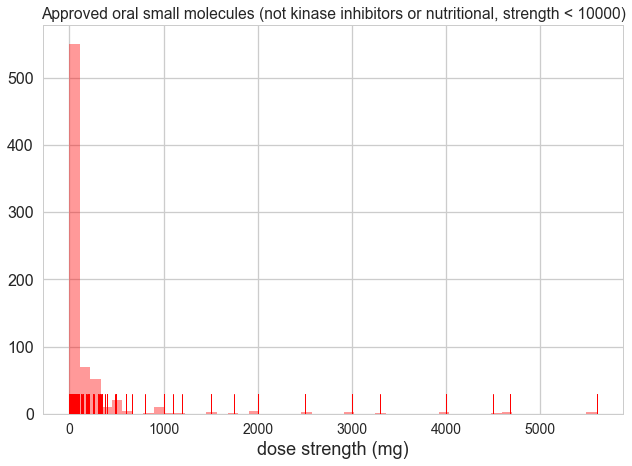

In [151]:
# Let's ignore 2 outlier molecules and focus to < 10000 mg region
# I want to plot only 0-1000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit_nonnut_nonki.shape[0])

x = np.array(df_drugbank_oral_fixed_unit_nonnut_nonki["min dosage strength value"].values, dtype=np.float64)
x = x[x <= 10000]
x = pd.Series(x, name="dose strength (mg)")
sns.distplot(x, hist= True, rug = True, kde = False, color = 'red')
plt.title("Approved oral small molecules (not kinase inhibitors or nutritional, strength < 10000)")
plt.savefig("dose_strength_histogram_of_approved_oral_small_molecules_strength10000.svg")
plt.savefig("dose_strength_histogram_of_approved_oral_small_molecules_strength10000.pdf")

Number of approved oral small molecules:
741
Number of approved oral kinase inhibitors:
47


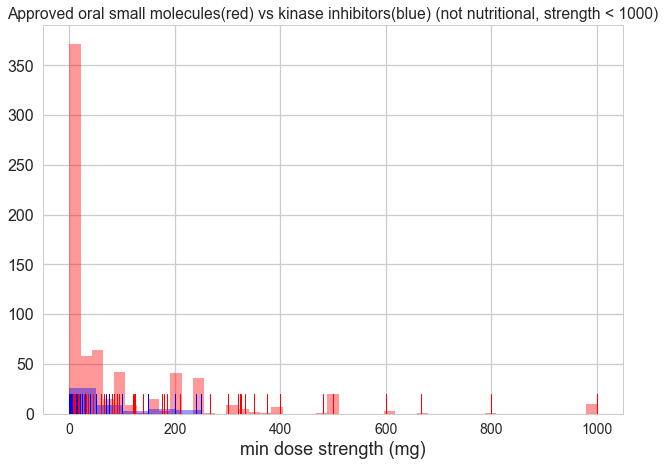

In [158]:
# I want to plot only 0-1000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit_nonnut_nonki.shape[0])

x = np.array(df_drugbank_oral_fixed_unit_nonnut_nonki["min dosage strength value"].values, dtype=np.float64)
x = x[x <= 1000]
x = pd.Series(x, name="Min dose strength (mg)")
sns.distplot(x, hist= True, rug = True, kde = False, color = 'red')

# Plot distribution for all approved oral kinase inhibitors
df_drugbank_oral_fixed_unit_kinase = df_drugbank_oral_fixed_unit.loc[df_drugbank_oral_fixed_unit["kinase inhibitor category"] == "True"]
print("Number of approved oral kinase inhibitors:")
print(df_drugbank_oral_fixed_unit_kinase.shape[0])

k = np.array(df_drugbank_oral_fixed_unit_kinase["min dosage strength value"].values, dtype=np.float64)
k = pd.Series(k, name="min dose strength (mg)")
sns.distplot(k, hist= True, rug = True, kde = False, color = 'blue')

plt.title("Approved oral small molecules(red) vs kinase inhibitors(blue) (not nutritional, strength < 1000)")
plt.savefig("dose_strength_hist_comparison_of_kinase_inh_and_other_oral_small_molecules_strength1000.svg")
plt.savefig("dose_strength_hist_comparison_of_kinase_inh_and_other_oral_small_molecules_strength1000.pdf")

Number of approved oral small molecules:
741
Number of approved oral kinase inhibitors:
47


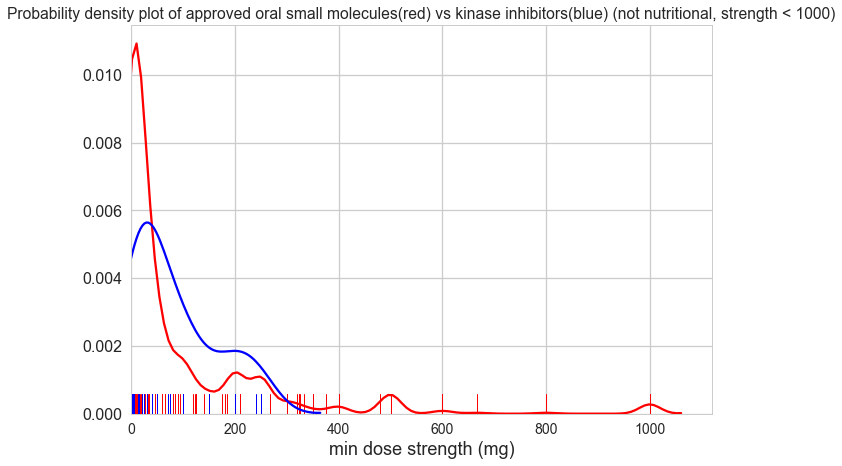

In [163]:
# I want to plot only 0-1000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit_nonnut_nonki.shape[0])

x = np.array(df_drugbank_oral_fixed_unit_nonnut_nonki["min dosage strength value"].values, dtype=np.float64)
x = x[x <= 1000]
x = pd.Series(x, name="min dose strength (mg)")
sns.distplot(x, hist= False, rug = True, kde = True, color = 'red')

# Plot distribution for all approved oral kinase inhibitors
df_drugbank_oral_fixed_unit_kinase = df_drugbank_oral_fixed_unit.loc[df_drugbank_oral_fixed_unit["kinase inhibitor category"] == "True"]
print("Number of approved oral kinase inhibitors:")
print(df_drugbank_oral_fixed_unit_kinase.shape[0])

k = np.array(df_drugbank_oral_fixed_unit_kinase["min dosage strength value"].values, dtype=np.float64)
k = pd.Series(k, name="min dose strength (mg)")
sns.distplot(k, hist= False, rug = True, kde = True, color = 'blue')

plt.xlim(0, None)
plt.title("Probability density plot of approved oral small molecules(red) vs kinase inhibitors(blue) (not nutritional, strength < 1000)")
plt.savefig("min_dose_strength_kde_comparison_of_kinase_inh_and_other_oral_small_molecules_strength1000.svg")
plt.savefig("min_dose_strength_kde_comparison_of_kinase_inh_and_other_oral_small_molecules_strength1000.pdf")

Number of approved oral small molecules:
741
Number of approved oral kinase inhibitors:
47


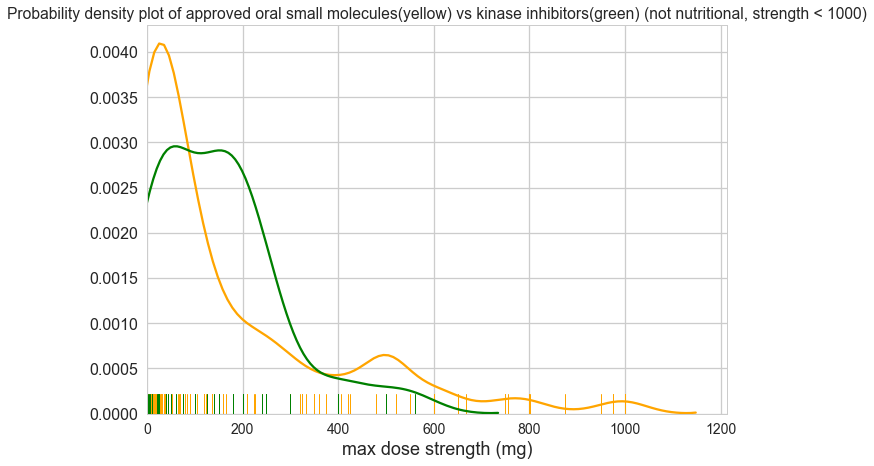

In [169]:
# I want to plot only 0-1000 mg region for all approved oral small molecule drugs.
print("Number of approved oral small molecules:")
print(df_drugbank_oral_fixed_unit_nonnut_nonki.shape[0])

x = np.array(df_drugbank_oral_fixed_unit_nonnut_nonki["max dosage strength value"].values, dtype=np.float64)
x = x[x <= 1000]
x = pd.Series(x, name="max dose strength (mg)")
sns.distplot(x, hist= False, rug = True, kde = True, color = 'orange')

# Plot distribution for all approved oral kinase inhibitors
df_drugbank_oral_fixed_unit_kinase = df_drugbank_oral_fixed_unit.loc[df_drugbank_oral_fixed_unit["kinase inhibitor category"] == "True"]
print("Number of approved oral kinase inhibitors:")
print(df_drugbank_oral_fixed_unit_kinase.shape[0])

k = np.array(df_drugbank_oral_fixed_unit_kinase["max dosage strength value"].values, dtype=np.float64)
k = pd.Series(k, name="max dose strength (mg)")
sns.distplot(k, hist= False, rug = True, kde = True, color = 'green')

plt.xlim(0, None)
plt.title("Probability density plot of approved oral small molecules(yellow) vs kinase inhibitors(green) (not nutritional, strength < 1000)")
plt.savefig("max_dose_strength_kde_comparison_of_kinase_inh_and_other_oral_small_molecules_strength1000.svg")
plt.savefig("max_dose_strength_kde_comparison_of_kinase_inh_and_other_oral_small_molecules_strength1000.pdf")

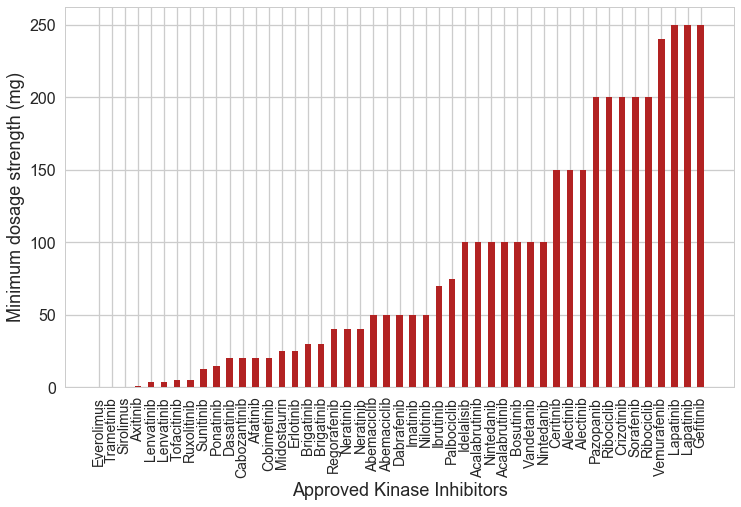

In [173]:
df_drugbank_sm_sorted = df_drugbank_oral_fixed_unit_kinase.sort_values("min dosage strength value",ascending=True)
df_drugbank_sm_sorted = df_drugbank_sm_sorted.reset_index(drop=True)

x = df_drugbank_sm_sorted.index
names = df_drugbank_sm_sorted["name"]
min_dosage = df_drugbank_sm_sorted["min dosage strength value"]

plt.close()
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

width = 0.5
plt.bar(x, min_dosage, width, color = "firebrick")
plt.xticks(x, names, rotation=90)
plt.xlabel("Approved Kinase Inhibitors")
plt.ylabel("Minimum dosage strength (mg)")
plt.tight_layout()

plt.savefig("min_dosage_strength_barplot_for_approved_small_molecules.pdf")

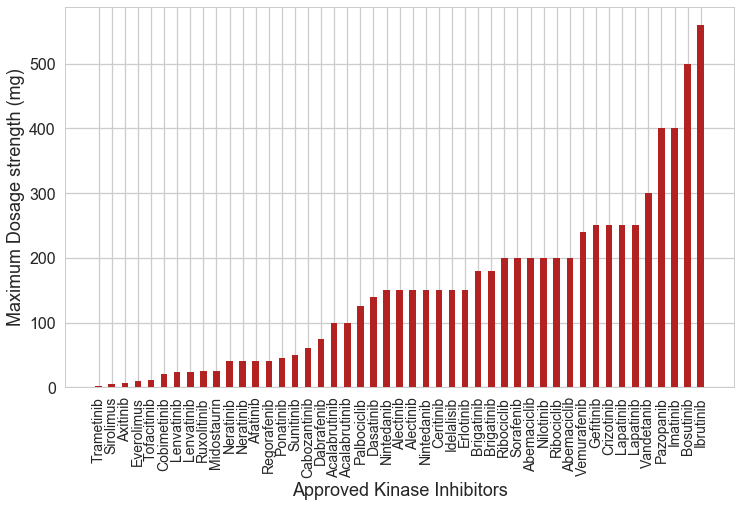

In [175]:
df_drugbank_ki_sorted = df_drugbank_oral_fixed_unit_kinase.sort_values("max dosage strength value",ascending=True)
df_drugbank_ki_sorted = df_drugbank_ki_sorted.reset_index(drop=True)

x = df_drugbank_ki_sorted.index
names = df_drugbank_ki_sorted["name"]

max_dosage = df_drugbank_ki_sorted["max dosage strength value"]

plt.close()
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

width = 0.5   
plt.bar(x, max_dosage, width, color = "firebrick")
plt.xticks(x, names, rotation=90)
plt.xlabel("Approved Kinase Inhibitors")
plt.ylabel("Maximum Dosage strength (mg)")
plt.tight_layout()

plt.savefig("max_dosage_strength_barplot_for_approved_kinase_inhibitors.pdf")

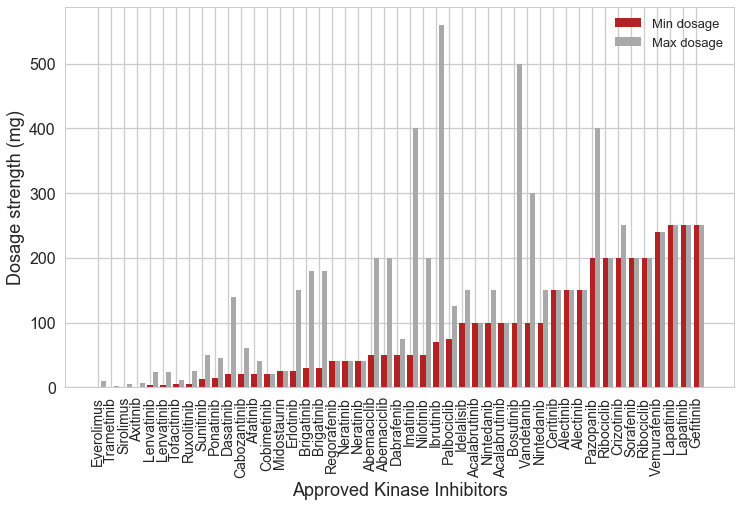

In [176]:
df_drugbank_ki_sorted = df_drugbank_oral_fixed_unit_kinase.sort_values("min dosage strength value",ascending=True)
df_drugbank_ki_sorted = df_drugbank_ki_sorted.reset_index(drop=True)

x = df_drugbank_ki_sorted.index
names = df_drugbank_ki_sorted["name"]
min_dosage = df_drugbank_ki_sorted["min dosage strength value"]
max_dosage = df_drugbank_ki_sorted["max dosage strength value"]

plt.close()
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

width = 0.4    
plt.bar(x, min_dosage, width, label = "Min dosage", color = "firebrick")
plt.bar(x+width, max_dosage, width, label = "Max dosage", color = "darkgrey")

plt.xticks(x , names, rotation=90)
plt.xlabel("Approved Kinase Inhibitors")
plt.ylabel("Dosage strength (mg)")
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("min_and_max_dosage_strength_barplot_for_approved_kinase_inhibitors.pdf")